In [60]:
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [61]:
import importlib
import gp
importlib.reload(gp)
from gp import *
import matplotlib.pyplot as plt


# Dataset characteristics<br>
- instant: record index<br>
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month (1 to 12)
- hr : hour (0 to 23)
- holiday : whether day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [3]:
import pandas as pd

df = pd.read_csv("hour.csv")
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


# Data Preprocess

In [4]:
reference_date = pd.Timestamp('2011-01-01')
df.iloc[:, 1] = (pd.to_datetime(df.iloc[:, 1]) - reference_date).dt.days
data = df.to_numpy(dtype=float)
data

array([[1.0000e+00, 0.0000e+00, 1.0000e+00, ..., 3.0000e+00, 1.3000e+01,
        1.6000e+01],
       [2.0000e+00, 0.0000e+00, 1.0000e+00, ..., 8.0000e+00, 3.2000e+01,
        4.0000e+01],
       [3.0000e+00, 0.0000e+00, 1.0000e+00, ..., 5.0000e+00, 2.7000e+01,
        3.2000e+01],
       ...,
       [1.7377e+04, 7.3000e+02, 1.0000e+00, ..., 7.0000e+00, 8.3000e+01,
        9.0000e+01],
       [1.7378e+04, 7.3000e+02, 1.0000e+00, ..., 1.3000e+01, 4.8000e+01,
        6.1000e+01],
       [1.7379e+04, 7.3000e+02, 1.0000e+00, ..., 1.2000e+01, 3.7000e+01,
        4.9000e+01]])

In [5]:
X_whole = data[:, 1:14] # the first column is index, not necessary
Y_whole = data[:, 16] # count of total rental bikes as label
X_whole 

array([[0.000e+00, 1.000e+00, 0.000e+00, ..., 2.879e-01, 8.100e-01,
        0.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 2.727e-01, 8.000e-01,
        0.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 2.727e-01, 8.000e-01,
        0.000e+00],
       ...,
       [7.300e+02, 1.000e+00, 1.000e+00, ..., 2.576e-01, 6.000e-01,
        1.642e-01],
       [7.300e+02, 1.000e+00, 1.000e+00, ..., 2.727e-01, 5.600e-01,
        1.343e-01],
       [7.300e+02, 1.000e+00, 1.000e+00, ..., 2.727e-01, 6.500e-01,
        1.343e-01]])

In [6]:
def standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X-mean)/std, mean, std

def split_train_test(X_whole, Y_whole, num=1500, rate=0.7):
    # Shuffle data first
    indices = jax.random.permutation(grab_prng(), X_whole.shape[0])
    X_part = X_whole[indices]
    Y_part = Y_whole[indices]
    
    indices = jax.random.permutation(grab_prng(), num)
    X_shuffled = X_part[indices]
    Y_shuffled = Y_part[indices]
    
    # Standardize the shuffled data
    X, mean, std = standardize(X_shuffled)
    Y, mean, std = standardize(Y_shuffled)

    # Use the same indices for Y
    # Y = Y_shuffled
    
    # Compute the split index
    split_idx = int(num * rate)
    
    # Split indices into train and test
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    # Split data using the indices
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    
    return X_train, Y_train, X_test, Y_test


In [7]:
def split_clml(X_train, Y_train, ratio=0.8):
    n_samples = X_train.shape[0]
    indices = jax.random.permutation(grab_prng(), n_samples)
    # Shuffle the data
    X_train_shuffled = X_train[indices]
    Y_train_shuffled = Y_train[indices]
    
    # Calculate the base size of each subset
    subset_size = int(n_samples * ratio)
    
    # Initialize lists to hold the subsets
    X_con = [X_train_shuffled[:subset_size], X_train_shuffled[subset_size:]]
    Y_con = [Y_train_shuffled[:subset_size], Y_train_shuffled[subset_size:]]
    
    return X_con, Y_con

def split_sequence(X_train, Y_train, seq_len=8):
    n_samples = X_train.shape[0]
    indices = jax.random.permutation(grab_prng(), n_samples)
     # Shuffle the data
    X_train_shuffled = X_train[indices]
    Y_train_shuffled = Y_train[indices]
    
    # Calculate the base size of each subset
    subset_size = n_samples // seq_len
    remainder = n_samples % seq_len
    
    # Initialize lists to hold the subsets
    X_seq = []
    Y_seq = []
    
    start_idx = 0
    for i in range(seq_len):
        # The first subset gets the remainder (extra) samples
        if i == 0:
            end_idx = start_idx + subset_size + remainder
        else:
            end_idx = start_idx + subset_size
        
        X_seq.append(X_train_shuffled[start_idx:end_idx])
        Y_seq.append(Y_train_shuffled[start_idx:end_idx])
        
        start_idx = end_idx
    return X_seq, Y_seq

In [8]:
X_train, Y_train, X_test, Y_test = split_train_test(X_whole, Y_whole, num=3000, rate=0.7)
X_con, Y_con = split_clml(X_train, Y_train, ratio=0.8)
X_seq, Y_seq = split_sequence(X_train, Y_train, seq_len=8)



# Hyperparameter initialization

Note that, in the below initialization, it is assumed that noise variance is the first component, signal variance the second, and length scale the third. Feel free to modify if using pytrees.

Further note: these are assumed constrained (strictly positive). You should map to unconstrained prior to running optimization, and map back to constrained when forming the GP posterior, and evaluating the predictive density for evaluation.

In [9]:
# def random_init_sqexp_hyperparams():
#     return np.array([jax.random.uniform(grab_prng(), minval=0.2, maxval=2),
#                      jax.random.uniform(grab_prng(), minval=0.2, maxval=2),
#                      X_train.shape[1]*jax.random.uniform(grab_prng(), minval=1, maxval=10)])
#

# Plotting code

In [24]:
def scatterplot(lml_lpd, label_x, label_y, tit):
    plt.scatter(lml_lpd[:,0], lml_lpd[:,1])
    
    # plt.xlabel('Log marginal likelihood')
    # plt.ylabel('Negative log predictive density')
    # plt.title('Is marginal likelihood a good indicator of generalization?')
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.title(tit)
    plt.legend()
#

# Experiment 1: Empirical Bayes for squared-exponential kernel

In [11]:
# n_trials = 20
# T = 200
# step_size = 5e-4

# gathered_trials = []
# hyperparams_inits = []
# for i in range(n_trials):
#    hyperparams_inits.append(random_init_sqexp_hyperparams())

# cov_func = sqexp_cov_function
# X_star = X_test
# for n in range(n_trials):
#    hyperparams_init = hyperparams_inits[n]
#    unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
   
#    # sqexp_cov_function(X_train, X_train, unconstrained_hyperparams_init)
   
#    (unconstrained_hyperparams, lml) = empirical_bayes(cov_func, X_train, Y_train, unconstrained_hyperparams_init, step_size, T)
#    hyperparams = param_transform(unconstrained_hyperparams)
   
#    posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
#    (posterior_mean, posterior_var) = posterior_predictive(X_star)
#    neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

#    posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
#    (posterior_mean, posterior_var) = posterior_predictive(X_star)
#    neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])

#    print(np.array([neg_log_initial, neg_log_final, lml]))
#    gathered_trials.append(np.array([neg_log_initial, neg_log_final, lml]))
# #
# gathered_trials

In [12]:
# trials_array = np.array(gathered_trials)
# lml_lpd = np.column_stack((trials_array[:, 2], trials_array[:, 1]))
# scatterplot(lml_lpd)


# Dicsussion
1. Negative log probability was consistently improved over the hyperparameters used at initialization, across all runs.
2. According to the scatterplot above, we can see that as log marginal likelihood increases, negative log predicitive density on test set decreases at first, and increases later. Log marginal likelihood is a metric of our hyperparameters. The larger log marginal likelihood is, the better our hyperparameters are. But if they are better is determined by training set. Thus it's reasonable that "better" hyperparameters on training set don't always work better on test set. A large marginal likelihood may cause overfitting, although it works very well on training set. It's not a good indicator of generalization.

# Experiment 2 - feature importance using learned Mahalanobis distances

In [13]:
# use as your initial hyperparameters -> first two parameters are noise variance and signal variance,
# remaining parameters are length scale; feel free to modify if using pytrees
def random_init_sqexp_maha_hyperparams(X_train):
    var = jax.random.uniform(grab_prng(), shape=(2,), minval=0.2, maxval=2)
    length_scale = jax.random.uniform(grab_prng(), shape=(X_train.shape[1],), minval=1, maxval=10)
    return np.concatenate([var, length_scale])


In [14]:
# experiment settings
n_trials = 20

cov_func = sqexp_mahalanobis_cov_function
X_star = X_test
hyperparams_inits = []
for i in range(n_trials):
   hyperparams_inits.append(random_init_sqexp_maha_hyperparams(X_train))


In [15]:
import importlib
import gp
importlib.reload(gp)
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# optimize hyperparameters according lml
lml_trials = []
T = 200
step_size = 1e-4
for n in range(n_trials):
   hyperparams_init = hyperparams_inits[n]
   unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
   (unconstrained_hyperparams, lml) = empirical_bayes(cov_func, X_train, Y_train, unconstrained_hyperparams_init, step_size, T)
   hyperparams = param_transform(unconstrained_hyperparams)
   
   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])
   print(np.array([neg_log_initial, neg_log_final, lml]))
   lml_trials.append(np.array([neg_log_initial, neg_log_final, lml]))
# #

[1053.82636063   50.07523785 1135.40995161]
[1143.69584877   73.45485445 1105.08390896]
[1221.21367785   23.15669911 1195.4806964 ]
[1090.62049949   29.85041769 1189.23128938]
[1060.21608331  180.85016556  912.28570724]
[1294.64771796  372.5271219   578.20739207]
[1028.36545296   19.89284705 1181.61782369]
[ 947.64039537  111.48275929 1025.6732048 ]
[1223.40985805   70.4715778  1069.60831844]
[ 875.98548359   19.724997   1186.90191436]
[ 937.81527986  127.11482909 1044.00060636]
[1228.49067082   35.91046129 1168.35991442]
[1100.9430315   182.11641642  870.55512226]
[1221.90758742  429.5746339   537.70445208]
[ 947.21838536  104.24130651 1029.64510004]
[1178.63749329  180.18118239  948.3296273 ]
[ 871.12598764   11.89032459 1214.73004341]
[ 968.52942943   52.23362618 1132.06436118]
[ 931.91408659   65.65623595 1093.85401007]
[1258.02617525  257.74096176  813.20032141]


C:\Users\Yue\AppData\Local\Temp\ipykernel_10308\1312685826.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


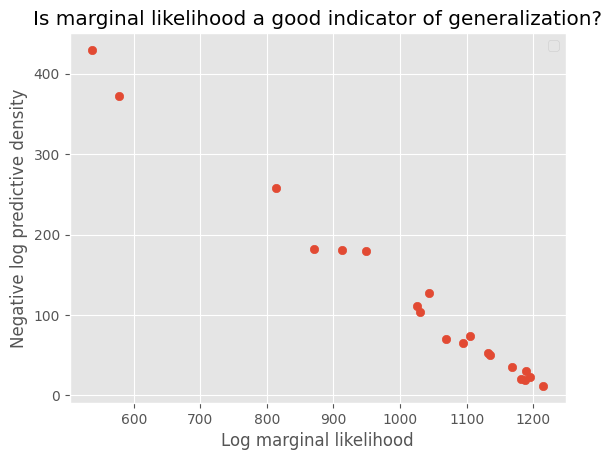

In [16]:
trials_array = np.array(lml_trials)
lml_lpd = np.column_stack((trials_array[:, 2], trials_array[:, 1]))
scatterplot(lml_lpd)

In [17]:
import importlib
import gp
importlib.reload(gp)
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# optimize hyperparameters according lml
clml_trials = []
T = 200
step_size = 1e-3
for n in range(n_trials):
   hyperparams_init = hyperparams_inits[n]
   unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
   (unconstrained_hyperparams, clml) = clml_opt(cov_func, X_con, Y_con, unconstrained_hyperparams_init, step_size, T)
   hyperparams = param_transform(unconstrained_hyperparams)
   
   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])
   print(np.array([neg_log_initial, neg_log_final, clml]))
   clml_trials.append(np.array([neg_log_initial, neg_log_final, clml]))

[1053.82636063  -22.30681419   -8.78666289]
[1143.69584877  -28.34275021  -15.81199089]
[1221.21367785  -30.1783915    -8.76750239]
[1090.62049949  -21.47919974   -7.70878511]
[1060.21608331  -29.35177471  -20.49867952]
[1294.64771796  -18.84784089  -19.94129413]
[1028.36545296  -36.36977162  -12.14445024]
[947.64039537 -24.15116848 -16.62992039]
[1223.40985805  -32.99255907  -16.3081361 ]
[875.98548359 -32.49751482 -11.08897058]
[937.81527986 -18.91267337  -7.51515317]
[1228.49067082  -31.30065312  -11.00745172]
[1100.9430315   -13.81784596  -17.9632114 ]
[1221.90758742  -16.77181174  -12.25074426]
[947.21838536 -20.57587148 -21.8295323 ]
[1178.63749329  -24.03490619  -11.84622782]
[871.12598764 -34.27626446 -10.03801853]
[968.52942943 -22.1952947  -12.92446705]
[931.91408659 -31.01742623 -16.33870966]
[1258.02617525  -25.74848929  -13.9348239 ]


C:\Users\Yue\AppData\Local\Temp\ipykernel_10308\1312685826.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


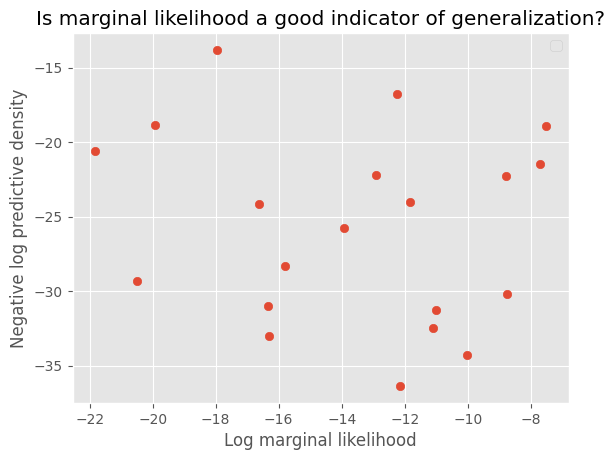

In [18]:
trials_array = np.array(clml_trials)
clml_lpd = np.column_stack((trials_array[:, 2], trials_array[:, 1]))
scatterplot(clml_lpd)

In [19]:
import importlib
import gp
importlib.reload(gp)
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [72]:
unconstrained_hyperparams=inverse_param_transform(hyperparams_inits[0])
# clml_function = conditional_log_marginal_likelihood(cov_func, X_con, Y_con)
# aaa=clml_function(unconstrained_hyperparams)

clmls_function = conditional_log_marginal_likelihood_sequence(cov_func, X_seq, Y_seq)
clml_vals=clmls_function(unconstrained_hyperparams)
clml_vals


Array([-296.25440919, -276.05768386, -266.11471867, -276.46281244,
       -265.59780351, -258.37449375, -247.92072448, -253.47985996,
       -247.60031757], dtype=float64)

-283.06026816441545 4.646767064594063


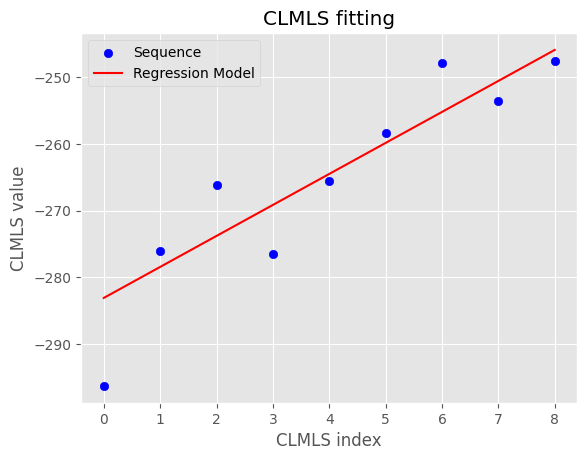

In [75]:
import importlib
import gp
importlib.reload(gp)
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')

a,b =opt_clmls(clml_vals)
print(a,b)
x_data = np.arange(len(clml_vals))
y_data = np.array(clml_vals)
x_fit = np.linspace(min(x_data), max(x_data), 100)  # Smooth x range for the fitted curve
y_fit = a + b * x_fit

# Plot the data
plt.scatter(x_data, y_data, color='blue', label='Sequence', zorder=5)

# Plot the fitted model
plt.plot(x_fit, y_fit, color='red', label='Regression Model', zorder=4)

# Add labels, legend, and title
plt.xlabel('CLMLS index')
plt.ylabel('CLMLS value')
plt.title('CLMLS fitting')
plt.legend()


In [22]:

import importlib
import gp
importlib.reload(gp)
from gp import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')



# optimize hyperparameters according lml
clmls_trials = []
T=200
step_size = 5e-3
for n in range(n_trials):
   hyperparams_init = hyperparams_inits[n]
   unconstrained_hyperparams_init = inverse_param_transform(hyperparams_init)
   (unconstrained_hyperparams, clmls) = clmls_opt(cov_func, X_seq, Y_seq, unconstrained_hyperparams_init, step_size, T)
   hyperparams = param_transform(unconstrained_hyperparams)
   
   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams_init)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_initial = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams_init[0])

   posterior_predictive = gp_posterior(cov_func, X_train, Y_train, hyperparams)
   (posterior_mean, posterior_var) = posterior_predictive(X_star)
   neg_log_final = neg_log_predictive_density(Y_test, posterior_mean, posterior_var, hyperparams[0])
   print(np.array([neg_log_initial, neg_log_final, clmls]))
   clmls_trials.append(np.array([neg_log_initial, neg_log_final, clmls]))

[1053.82636063   -7.01643264   30.03537282]
[1143.69584877   -2.34811103   30.13503358]
[1221.21367785   -7.48695966   30.08375057]
[1090.62049949   -6.72370472   29.8145673 ]
[1060.21608331   14.17146362   28.30689223]
[1294.64771796   -3.71011211   29.6664496 ]
[1.02836545e+03 2.86279183e-01 2.97293810e+01]
[947.64039537  -2.00148812  31.1793855 ]
[1223.40985805    3.98773373   29.70532996]
[875.98548359   3.06574791  29.53205861]
[937.81527986  -7.88042226  29.72630314]
[1228.49067082   -8.28666994   29.88162135]
[1100.9430315    -3.99284851   28.64566431]
[1221.90758742   -9.71224769   30.14846871]
[947.21838536  20.44159599  28.5456953 ]
[1178.63749329    6.79124025   29.24563308]
[871.12598764   3.37675776  29.84052478]
[968.52942943   4.52367834  29.42208146]
[931.91408659  -6.4249131   29.23351001]
[1258.02617525   -8.1060411    30.15050535]


In [52]:
trials_array = np.array(clmls_trials)
clmls_lpd = np.column_stack((trials_array[:, 2], trials_array[:, 1]))
scatterplot(clmls_lpd)

TypeError: scatterplot() missing 3 required positional arguments: 'label_x', 'label_y', and 'tit'

C:\Users\Yue\AppData\Local\Temp\ipykernel_10308\1867195997.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


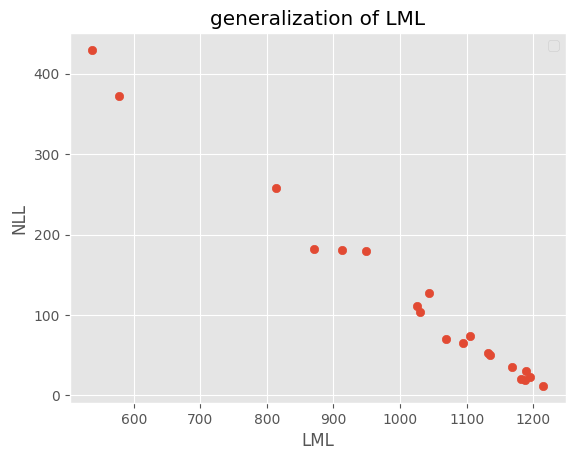

In [ ]:
scatterplot(lml_lpd, 'LML', 'NLL', 'Generalization of LML')

C:\Users\Yue\AppData\Local\Temp\ipykernel_10308\1867195997.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


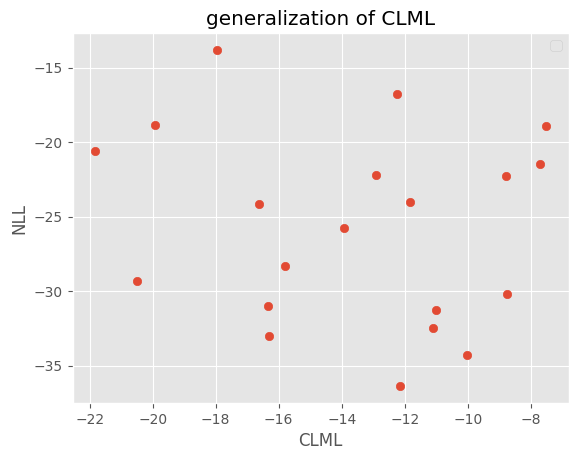

In [ ]:

scatterplot(clml_lpd, 'CLML', 'NLL', 'Generalization of CLML')

C:\Users\Yue\AppData\Local\Temp\ipykernel_10308\1867195997.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


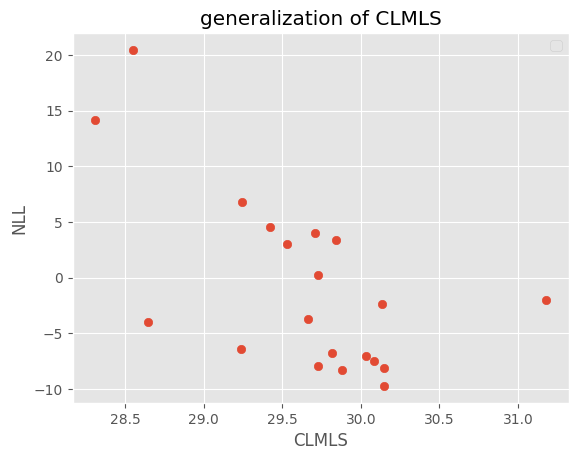

In [ ]:

scatterplot(clmls_lpd, 'CLMLS', 'NLL', 'Generalization of CLMLS')

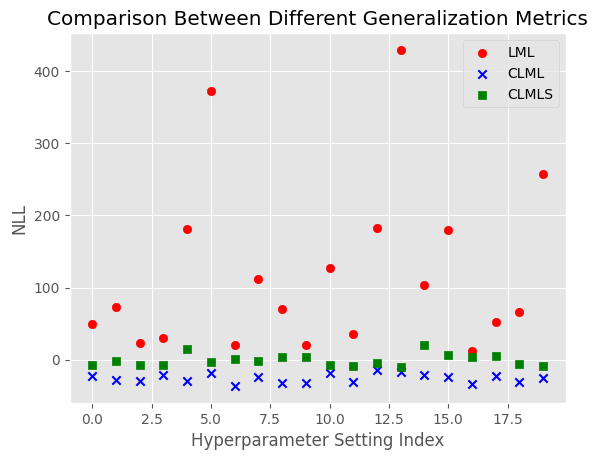

In [68]:
lml = lml_lpd[:, 1]
clml = clml_lpd[:, 1]
clmls = clmls_lpd[:, 1]

# Plot the scatter plots
plt.scatter(range(len(lml)), lml, label="LML", color="red", marker="o")
plt.scatter(range(len(clml)), clml, label="CLML", color="blue", marker="x")
plt.scatter(range(len(clmls)), clmls, label="CLMLS", color="green", marker="s")

# Add labels, title, and legend
plt.xlabel("Hyperparameter Setting Index")
plt.ylabel("NLL")
plt.title("Comparison Between Different Generalization Metrics")
plt.legend()

# Show the plot
plt.show()

In [69]:
hyperparams_inits[0]

Array([0.79073322, 1.63487363, 7.40694554, 3.85240339, 2.78193257,
       4.88652673, 2.90733816, 7.83089076, 5.98953301, 8.14945172,
       2.83408838, 6.11504209, 2.41963785, 3.50070276, 6.43582522],      dtype=float64)